In [1]:
import pandas as pd
import numpy as np

# modeling
import keras
from keras.utils import pad_sequences
from keras.layers import Dense, Dropout, LSTM, Lambda
from keras.models import Sequential, Model, load_model
import tensorflow as tf

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Reading in Pollution Data


In [2]:
pollution_df = pd.read_csv(
    "../data/aarhus_pollution_data_aug_oct_2014.csv")
pollution_df["timestamp"] = pd.to_datetime(pollution_df['timestamp'])

pollution_features = ["particullate_matter",
                      "carbon_monoxide", 
                      "sulfure_dioxide", 
                      "nitrogen_dioxide"]

pollution_df = pollution_df.groupby(
    "timestamp").agg({"particullate_matter": np.mean,
                      "carbon_monoxide": np.mean,
                      "sulfure_dioxide": np.mean,
                      "nitrogen_dioxide": np.mean
                      })

pollution_df.head()

/var/folders/0f/glx6yb212vlc0p67p0phsp180000gn/T/ipykernel_20210/2121407104.py:11: FutureWarning: The provided callable <function mean at 0x10d2df740> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  "timestamp").agg({"particullate_matter": np.mean,


,particullate_matter,carbon_monoxide,sulfure_dioxide,nitrogen_dioxide
timestamp,,,,
2014-08-01 00:05:00,62.124722,62.044543,61.380846,61.915367
2014-08-01 00:10:00,62.385301,62.144766,61.599109,61.788419
2014-08-01 00:15:00,62.269488,62.075724,61.538976,61.922049
2014-08-01 00:20:00,62.427617,62.060134,61.483296,62.109131
2014-08-01 00:25:00,62.692650,62.100223,61.454343,62.262806


In [3]:
pollution_df.shape

(17568, 4)

In [4]:
training_sample = pollution_df[100:13000]
validation_sample = pollution_df[13001:]

validation_sample.shape

(4567, 4)

In [5]:
def create_sequence_training_set(training_sample, seq_length, pred_horizon, input_features, output_features):
    seq_arrays = []
    seq_labs = []
    for i in range(training_sample.shape[0] - seq_length - pred_horizon):
        seq_arrays.append(training_sample.iloc[i:seq_length+i, :input_features].to_numpy())
        seq_labs.append(training_sample.iloc[seq_length+pred_horizon+i, :output_features])

    seq_arrays = np.array(seq_arrays, dtype=object).astype(np.float32)
    seq_labs = np.array(seq_labs, dtype=object).astype(np.float32)
    return seq_arrays, seq_labs

# create validation dataset
def create_validation_set(validation_sample, seq_length, pred_horizon, input_features, output_features):
    val_arrays = []
    val_labs = []
    for i in range(validation_sample.shape[0] - seq_length - pred_horizon):
        if i < seq_length:
            val_arrays.append(validation_sample.iloc[:(i+1), :input_features].to_numpy())
            val_labs.append(validation_sample.iloc[:(i+pred_horizon+1), :output_features].to_numpy()[-1])
        else:
            val_arrays.append(validation_sample.iloc[i:seq_length+i, :input_features].to_numpy())
            val_labs.append(validation_sample.iloc[seq_length+i+pred_horizon, :output_features])

    val_arrays = pad_sequences(val_arrays, padding='pre', dtype=object).astype(np.float32)
    val_labs = np.array(val_labs, dtype=object).astype(np.float32)
    return val_arrays, val_labs

In [6]:
# set predictive horizon and sequence length
ph = 5
seq_length = 12

# features to randomly sample without replacement
# must be a value between 1 to 4, inclusive

input_features = 4
output_features = 4

sensor = pd.Series(training_sample.columns).sample(
    input_features, replace=False).sort_values().to_list()


seq_arrays, seq_labs = create_sequence_training_set(
    training_sample, seq_length, ph, input_features, output_features)

val_arrays, val_labs = create_validation_set(
    validation_sample, seq_length, ph, input_features, output_features)

In [8]:
def train_lstm_model(model_path, seq_length, seq_arrays, seq_labs, input_features, output_features):
    # define path to save model
    model_path = model_path

    # build the network
    output_size = output_features

    model = Sequential()

    model.add(LSTM(
        input_shape=(seq_length, input_features),
        units=100, activation="relu", return_sequences=True))

    model.add(LSTM(units=64, activation="relu", return_sequences=True))

    model.add(LSTM(units=32, activation="relu", return_sequences=False))

#    model.add(Dense(units=output_size, activation="relu"))

    model.add(Dense(units=output_size, activation="linear", use_bias=True))

    #bias_correction = tf.constant([0.5] * output_size, dtype=tf.float32)
    #model.add(Lambda(lambda x: x + bias_correction))
    
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss='mean_absolute_error',
                  optimizer=optimizer, metrics=['mae'])

    print(model.summary())

    # fit the network
    history = model.fit(seq_arrays,
                        seq_labs,
                        epochs=1000,
                        batch_size=80,
                        validation_split=0.05,
                        verbose=2,
                        callbacks=[
                            keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                min_delta=0.05,
                                patience=10,
                                verbose=0,
                                mode='min'),
                            keras.callbacks.ModelCheckpoint(
                                model_path,
                                monitor='val_loss',
                                save_best_only=True,
                                mode='min',
                                verbose=0)
                        ])

    return model, history

In [9]:
model, history = train_lstm_model('../models/lstm_pollution.keras',
                                  seq_length,
                                  seq_arrays,
                                  seq_labs,
                                  input_features, 
                                  output_features)
# list all data in history
print(history.history.keys())

/opt/homebrew/anaconda3/envs/masters/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 100)        │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 64)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,788 (378.08 KB)

 Trainable params: 96,788 (378.08 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
153/153 - 5s - 31ms/step - loss: 17.6782 - mae: 17.6782 - val_loss: 1.3260 - val_mae: 1.3260
Epoch 2/1000
153/153 - 3s - 21ms/step - loss: 1.2101 - mae: 1.2101 - val_loss: 0.9803 - val_mae: 0.9803
Epoch 3/1000
153/153 - 4s - 25ms/step - loss: 0.9746 - mae: 0.9746 - val_loss: 1.1587 - val_mae: 1.1587
Epoch 4/1000
153/153 - 3s - 22ms/step - loss: 0.8087 - mae: 0.8087 - val_loss: 0.8496 - val_mae: 0.8496
Epoch 5/1000
153/153 - 3s - 22ms/step - loss: 0.7938 - mae: 0.7938 - val_loss: 0.6937 - val_mae: 0.6937
Epoch 6/1000
153/153 - 3s - 21ms/step - loss: 0.7560 - mae: 0.7560 - val_loss: 0.7552 - val_mae: 0.7552
Epoch 7/1000
153/153 - 4s - 23ms/step - loss: 0.7838 - mae: 0.7838 - val_loss: 0.8093 - val_mae: 0.8093
Epoch 8/1000
153/153 - 3s - 23ms/step - loss: 0.6609 - mae: 0.6609 - val_loss: 0.7673 - val_mae: 0.7673
Epoch 9/1000
153/153 - 3s - 21ms/step - loss: 0.9102 - mae: 0.9102 - val_loss: 0.6602 - val_mae: 0.6602
Epoch 10/1000
153/153 - 3s - 19ms/step - loss: 0.6583 - m

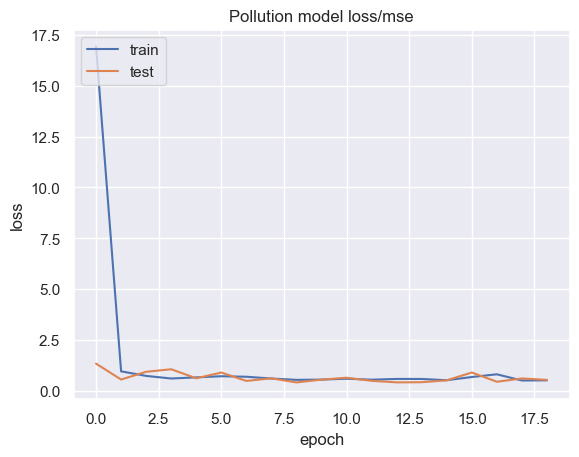

143/143 - 0s - 3ms/step - loss: 0.8756 - mae: 0.8756

MSE: 0.8755826354026794


In [158]:
def summarize_history_loss(history, title):
    # summarize history for Loss/MSE
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

summarize_history_loss(history, "Pollution model loss/mse")

scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


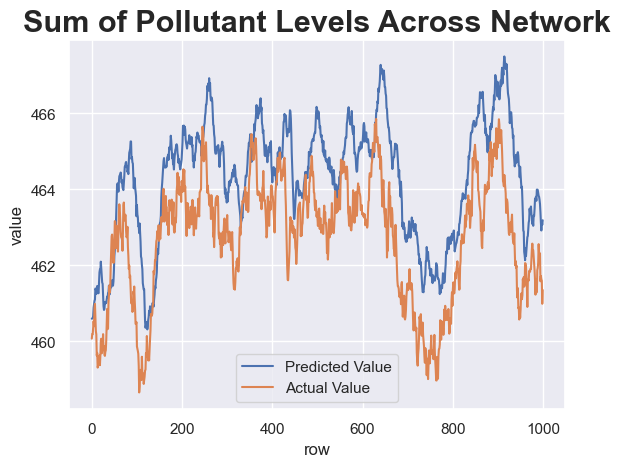

In [167]:
def plot_prediction_across_network(model, val_arrays, val_labs, title):
    y_pred_test = model.predict(val_arrays)
    y_true_test = val_labs

    # aggregating for easier visualization
    y_pred_dv = [row.sum() for row in y_pred_test]
    y_true_dv = [row.sum() for row in y_true_test]

    start = 1000
    ts = 1000

    plt.plot(y_pred_dv[start:start+ts], label='Predicted Value')
    plt.plot(y_true_dv[start:start+ts], label='Actual Value')
    plt.title(title,
            fontsize=22, fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend()
    plt.show()

plot_prediction_across_network(model, val_arrays, val_labs, 'Sum of Pollutant Levels Across Network')

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


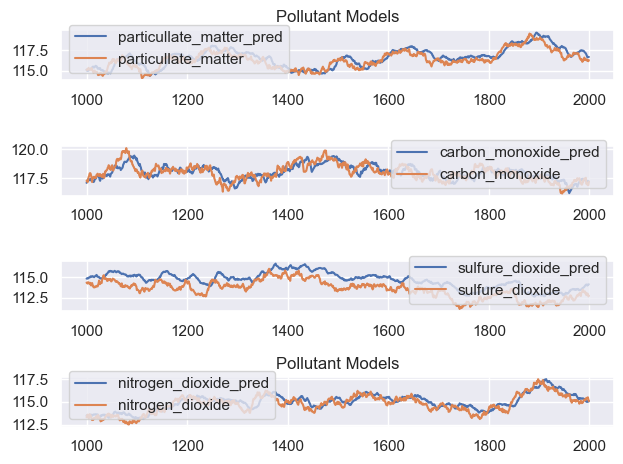

In [166]:
def plot_prediction_across_network_2(model, val_arrays, val_labs, title):
    y_pred_test = pd.DataFrame(model.predict(
        val_arrays), columns=pollution_features)
    y_true_test = pd.DataFrame(val_labs, columns=pollution_features)

    start = 1000
    ts = 1000

    fig, ax = plt.subplots(4, 1)

    for _, ax in enumerate(ax):
        if (_ == 0):
            ax.set_title(title)
        feature = pollution_features[_]

        ax.plot(y_pred_test[feature][start:start+ts], label=feature + "_pred")
        ax.plot(y_true_test[feature][start:start+ts], label=feature)
        ax.legend()

    ax.set_title(title)

    fig.set_tight_layout("tight")
    plt.show()


plot_prediction_across_network_2(
    model, val_arrays, val_labs, 'Pollutant Models')

# Additional Code to Create Data Visualization Dataset

In [177]:
pred_cols = [f"{feature}_pred" for feature in pollution_features]

y_pred_test = pd.DataFrame(model.predict(
    val_arrays), columns=pred_cols)

y_true_test = pd.DataFrame(val_labs, columns=pollution_features)

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [178]:
y_pred_test_sample = y_pred_test

dv_data = validation_sample.iloc[-y_pred_test_sample.shape[0]:]
dv_data.iloc[-1000:] = np.nan

y_pred_test_sample.index = dv_data.index
y_pred_test_sample.iloc[:y_pred_test_sample.shape[0]-1000] = np.nan

dv_data = dv_data.merge(y_pred_test_sample,
                        how="left",
                        left_index=True,
                        right_index=True)


dv_data["timestamp"] = dv_data.index

dv_data = pd.melt(dv_data, id_vars="timestamp")
dv_data.set_index("timestamp", drop=True, inplace=True)

dv_data

/var/folders/29/b1zgt_4148qbjk0pt48_ybym0000gn/T/ipykernel_41861/3590179956.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dv_data.iloc[-1000:] = np.nan


,variable,value
timestamp,,
2014-09-15 04:55:00,particullate_matter,111.042316
2014-09-15 05:00:00,particullate_matter,111.391982
2014-09-15 05:05:00,particullate_matter,111.209354
2014-09-15 05:10:00,particullate_matter,111.320713
2014-09-15 05:15:00,particullate_matter,111.173719
...,...,...
2014-09-30 23:40:00,nitrogen_dioxide_pred,113.943611
2014-09-30 23:45:00,nitrogen_dioxide_pred,113.897461
2014-09-30 23:50:00,nitrogen_dioxide_pred,113.946907


In [179]:
dv_data.to_csv("aai-530-final-project-pollution_models.csv")